In [71]:
import fns
from fns import *
from fns.functionsTF import *
%matplotlib inline

today = datetime.date.today()
todayStr = '%04d%02d%02d' % (today.year, today.month, today.day)
# todayStr = '20151005'
DIRECTORY = os.path.expanduser("~/Dropbox/0000_PhD/figures/"+todayStr+"/")
CSV_DIR_TODAY = os.path.expanduser("~/Dropbox/0000_PhD/csv/"+todayStr+"/")
CSV_DIR = os.path.expanduser("~/Dropbox/0000_PhD/csv/")
FIG_DIR = os.path.expanduser("~/Dropbox/0000_PhD/figures/")
if not os.path.exists(DIRECTORY):
    os.makedirs(DIRECTORY)
    
from bokeh.io import output_notebook
output_notebook()
from IPython.display import clear_output, Image, display

Loading BokehJS ...

In [72]:
def f():
    plt.figure(figsize=(20,3), linewidth=0.1)

In [73]:

class TfSingleNet:

    def __init__(self, N=400,
                 T=400,
                 disp=False,
                 spikeMonitor=False,
                 input=None,
                 tauv=15,
                 device='/gpu:0',
                 NUM_CORES=1,
                 g0=7,
                 nu=100,
                 ratioNI = 0.2,
                 startPlast=500,
                 memfraction=0.95):
        tf.reset_default_graph()
        self.N = N
        self.NI = int(N * ratioNI)
        self.NE = int(N - self.NI)
        self.T = T
        self.disp = disp
        self.spikeMonitor = spikeMonitor
        self.tauv = tauv
        self.g = g0
        self.g0fromFile = False
        self.device = device
        self.startPlast = startPlast
        self.raster = []
        self.nu = nu
        self.nuI = nu
        self.nuE = nu
        self.ratio = 1
        self.FACT = 10
        self.lowspthresh = 1.5
        self.weight_step = 100
        self.wII = 700
        self.wEE = 700
        self.wEI = 1000
        self.wIE = -1000
        gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=memfraction)

        self.sess = tf.InteractiveSession(config=tf.ConfigProto(
            inter_op_parallelism_threads=NUM_CORES,
            intra_op_parallelism_threads=NUM_CORES,
            gpu_options=gpu_options,
            device_count={'GPU': (device[:4] == '/gpu') * 1}
        )
        )
        if input is None:
            self.input = np.ones((T, 1))

    def varname(self):
        d = {v: k for k, v in globals().items()}
        return d[self]

    def DisplayArray(self, a, fmt='jpeg', rng=[0, 1], text=""):
        """Display an array as a picture."""
        a = (a - rng[0]) / float(rng[1] - rng[0]) * 255
        a = np.uint8(np.clip(a, 0, 255))
        f = BytesIO()
        PIL.Image.fromarray(np.uint8(plt.cm.YlGnBu_r(a) * 255)).save(f, fmt)
        display(Image(data=f.getvalue()))
        print(text)

    def init_float(self, shape, name):
        #     return tf.Variable(tf.random_normal(shape, stddev=0.01), name=name)
        return tf.Variable(tf.zeros(shape), name=name)

    def variable_summaries(self, var, name):
        """Attach a lot of summaries to a Tensor."""
        with tf.name_scope('summaries'):
            mean = tf.reduce_mean(var)
            tf.scalar_summary('mean/' + name, mean)
            with tf.name_scope('stddev'):
                stddev = tf.sqrt(tf.reduce_sum(tf.square(var - mean)))
            tf.scalar_summary('sttdev/' + name, stddev)
            tf.scalar_summary('max/' + name, tf.reduce_max(var))
            tf.scalar_summary('min/' + name, tf.reduce_min(var))
            tf.histogram_summary(name, var)
        return 0

    def runTFSimul(self):
        #################################################################################
        ### INITIALISATION
        #################################################################################
        N = self.N
        NI = self.NI
        NE = self.NE
        T = self.T
        with tf.device(self.device):
            scaling = 1 / (1 / (2 * 2 / self.dt)) ** 0.5 * 70

            with tf.name_scope('membrane_var'):
                # Create variables for simulation state
                u = self.init_float([N, 1], 'u')
#                 v = self.init_float([N, 1], 'v')
                v = tf.Variable(tf.ones([N,1])*-70, name='v')
                # currents
                iBack = self.init_float([N, 1], 'iBack')
                iChem = self.init_float([N, 1], 'iChem')
                I = tf.Variable(tf.zeros([N,1]), name='I')
                input = tf.cast(tf.constant(self.input, name="input"), tf.float32)

            with tf.name_scope('spiking_bursting'):
                LowSp = self.init_float([N, 1], 'bursting')
                vv = self.init_float([N, 1], 'spiking')

            with tf.name_scope('monitoring'):
                vmE = self.init_float([T], "vm")
                vmI = self.init_float([T], "vm")
                umE = self.init_float([T], "um")
                umI = self.init_float([T], "um")
                vvmE = self.init_float([T], "vvm")
                vvmI = self.init_float([T], "vvm")
                pmE = self.init_float([T], "pm")
                pmI = self.init_float([T], "pm")
                lowspm = self.init_float([T], "lowspm")
                imE = self.init_float([T], "imE")
                imI = self.init_float([T], "imI")
                icmE = self.init_float([T], "icmE")
                icmI = self.init_float([T], "icmI")
                gm = self.init_float([T//self.weight_step + 1], "gm")
                iEffm = self.init_float([T], "iEffm")
                spikes = self.init_float([T, N], "spikes")

            with tf.name_scope('synaptic_connections'):
                # synaptics connection
                # conn = tf.constant(np.ones((N, N), dtype='float32') - np.diag(np.ones((N,), dtype='float32')))
                conn, connEE, connII, connEI, connIE = makeConn(N, NE=NE, NI=NI)
                vectE, vectI = makeVect(N, NE=NE, NI=NI)


                self.conn = conn.eval()
                nbOfGaps = NI*(NI-1)


                if self.g0fromFile:
                    self.g = getGSteady(self.tauv, 5, 1000)
                g0 = self.g / (nbOfGaps**0.5)
                wGap_init = (tf.random_normal((N, N), mean=g0, stddev=g0/2, dtype=tf.float32,
                                              seed=None, name=None))

                wII_init = self.wII / ((NI*(NI-1))**0.5) / self.dt
                if NE>0:
                    wEE_init = self.wEE / ((NE*(NE-1))**0.5) / self.dt
                else:
                    wEE_init = 0
                wIE_init = self.wIE / (NI*NE-1)**0.5 / self.dt
                wEI_init = self.wEI / (NI*NE-1)**0.5 / self.dt
		
                print('wII, wEE', wII_init, wEE_init)
                wGap = tf.Variable(tf.mul(wGap_init, connII))
                WII = tf.Variable(tf.mul(wII_init, connII))
                WEE = tf.Variable(tf.mul(wEE_init, connEE))
                WEI = tf.Variable(tf.mul(wEI_init, connEI))
                WIE = tf.Variable(tf.mul(wIE_init, connIE))
                

                # plasticity learning rates
                A_LTD_ = 2.45e-5 * self.FACT * 400 / N
                A_LTD = tf.constant(A_LTD_, name="A_LTP", dtype=tf.float32)
                A_LTP = tf.constant(self.ratio * A_LTD_, name="A_LTD", dtype=tf.float32)

            with tf.name_scope("simulation_params"):
                # stimulation

                TImean = tf.constant(self.nu * 1.0, name="mean_input_current", dtype=tf.float32)
                if self.nuI != self.nuE:
                    TImean = tf.constant(self.nuI * 1.0, name="mean_input_current", dtype=tf.float32)*vectI + \
                            tf.constant(self.nuE * 1.0, name="mean_input_current", dtype=tf.float32)*vectE
                    
                
                # timestep
                dt = tf.constant(self.dt * 1.0, name="timestep", dtype=tf.float32)
                tauv = tf.constant(self.tauv*1.0, dtype=tf.float32)

                startPlast = self.startPlast
                weight_step = self.weight_step

            sim_index = tf.Variable(0.0, name="sim_index")
            one = tf.Variable(1.0)
            ones = tf.ones((1, N))
            
            

        #################################################################################
        ## Computation
        #################################################################################
        with tf.device(self.device):
            with tf.name_scope('Currents'):
                # Discretized PDE update rules
                ps([WII, vv, vectI])

                iChem_ = iChem + \
                          dt / 5 * (-iChem + tf.matmul(WII + WEI, tf.to_float(vv))) + \
                         dt / 10 * (-iChem + tf.matmul(WEE + WIE, tf.to_float(vv)))
                # current
                iBack_ = iBack + dt / 5 * (-iBack + tf.random_normal((N, 1), mean=0.0, stddev=1.0, dtype=tf.float32,
                                                                     seed=None, name=None))
                input_ = input[tf.to_int32(sim_index)]

                # input to network: colored noise + external input
                iEff_ = iBack_ * scaling + input_ + TImean

                iGap_ = (tf.matmul(wGap, v) - tf.mul(tf.reshape(tf.reduce_sum(wGap, 0), (N, 1)), v))*vectI

                I_ = iGap_ + iChem_ + iEff_
                ps([I_, iGap_, iEff_, input_, iBack_, iChem_])

            # IZHIKEVICH
            with tf.name_scope('Izhikevich'):
                # voltage
                v_ = tf.mul(v + dt / tauv * (tf.mul((v + 60), (v + 50)) - 20 * u + 8 * I_), vectI) + \
                    tf.mul(v + dt / 10 * (0.7 *  (v + 60) * (v + 40) - u + I_ ), vectE)
                # adaptation
                u_ = u + tf.mul(dt * 0.044 * (v_ + 55 - u), vectI) + \
                    tf.mul(dt * 0.03 * (-2 * (v + 60) - u), vectE)
                # spikes
                vv_ = tf.mul(tf.to_float(tf.greater(v_, 25.0)), vectI) + \
                    tf.mul(tf.to_float(tf.greater(v_, 35.0)), vectE)
                # reset
                v_ = tf.mul(vv_, -40.0)*vectI + tf.mul(vv_, -50.0)*vectE + tf.mul((1 - vv_), v_)

                u_ = u_ + 50*vv_*vectI + 100*vectE*vv_

            # bursting
            with tf.name_scope('bursting'):
                LowSp_ = (LowSp + dt / 8.0 * (vv_ * 8.0 / dt - LowSp))
                p_ = tf.to_float(tf.greater(LowSp_, 1.5))

            # plasticity
            with tf.name_scope('plasticity'):
                A = tf.matmul(p_, ones, name="bursts")  # bursts
                B = tf.matmul(vv_ * vectI, ones, name="spikes")  # spikes

                dwLTD_ = A_LTD * tf.add(A, tf.transpose(A, name="tr_bursts"))
                dwLTP_ = A_LTP * tf.add(B, tf.transpose(B, name="tr_spikes"))

                dwGap_ = dt * tf.sub(dwLTP_, dwLTD_)
                wGap_ = tf.clip_by_value(wGap + dwGap_, clip_value_min=0, clip_value_max=10 ** 10)

            # monitoring
            with tf.name_scope('Monitoring'):
                vvmeanE_ = tf.reduce_sum(vv_*vectE)
                vvmeanI_ = tf.reduce_sum(vv_*vectI)
                vmeanE_ = tf.reduce_mean(v_*vectE)
                vmeanI_ = tf.reduce_mean(v_*vectI)
                umeanE_ = tf.reduce_mean(u_*vectE)
                umeanI_ = tf.reduce_mean(u_*vectI)
                pmeanE_ = tf.reduce_mean(p_*vectE)
                pmeanI_ = tf.reduce_mean(p_*vectI)
                lowspmean_ = tf.reduce_mean(LowSp_)
                imeanE_ = tf.reduce_mean(I_*vectE)
                imeanI_ = tf.reduce_mean(I_*vectI)
                icmeanE_ = tf.reduce_mean(iChem_*vectE)
                icmeanI_ = tf.reduce_mean(iChem_*vectI)
                iEffm_ = tf.reduce_mean(iEff_)
                update = tf.group(
                    tf.scatter_update(vvmE, tf.to_int32(sim_index), vvmeanE_),
                    tf.scatter_update(vvmI, tf.to_int32(sim_index), vvmeanI_),
                    tf.scatter_update(vmE, tf.to_int32(sim_index), vmeanE_),
                    tf.scatter_update(vmI, tf.to_int32(sim_index), vmeanI_),
                    tf.scatter_update(umE, tf.to_int32(sim_index), umeanE_),
                    tf.scatter_update(umI, tf.to_int32(sim_index), umeanI_),
                    tf.scatter_update(pmE, tf.to_int32(sim_index), pmeanE_),
                    tf.scatter_update(pmI, tf.to_int32(sim_index), pmeanI_),
                    tf.scatter_update(lowspm, tf.to_int32(sim_index), lowspmean_),
                    tf.scatter_update(imE, tf.to_int32(sim_index), imeanE_),
                    tf.scatter_update(imI, tf.to_int32(sim_index), imeanI_),
                    tf.scatter_update(icmE, tf.to_int32(sim_index), icmeanE_),
                    tf.scatter_update(icmI, tf.to_int32(sim_index), icmeanI_),
                    tf.scatter_update(iEffm, tf.to_int32(sim_index), iEffm_),
                    sim_index.assign_add(one),
                )

            with tf.name_scope('Weights_monitoring'):
                gm_ = tf.reduce_sum(wGap*connII)
                update_weights = tf.group(
                    tf.scatter_update(gm, tf.to_int32(sim_index / weight_step), gm_),
                )

            with tf.name_scope('Raster_Plot'):
                spike_update = tf.group(
                    tf.scatter_update(spikes, tf.to_int32(sim_index), tf.reshape((vv_), (N,))),
                )

            # Operation to update the state
            step = tf.group(
                iChem.assign(iChem_),
                iBack.assign(iBack_),
                LowSp.assign(LowSp_),
                v.assign(v_),
                vv.assign(vv_),
                u.assign(u_),
            )

            plast = tf.group(
                wGap.assign(wGap_),
            )

            # update_index = tf.group(
            #     sim_index.assign_add(one),
            # )


            # initialize the graph
            tf.global_variables_initializer().run()
            
            self.WII = WII.eval()
            self.WEE = WEE.eval()
            self.WIE = WIE.eval()
            self.WEI = WEI.eval()

            t0 = time.time()
            for i in range(T):

                # Step simulation
                ops = {'plast': [step, plast, update],
                       'static': [step, update]
                       }
                if self.spikeMonitor:
                    for k, v in ops.items():
                        ops[k] = v + [spike_update]

                if i>startPlast:
                    self.sess.run(ops['plast'])
                else:
                    self.sess.run(ops['static'])

                if i % weight_step == 0:
                    self.sess.run([update_weights])

                # self.sess.run([update_index])

                # Visualize every X steps
                if i % 1 == 0:
                    if self.disp:
                        clear_output(wait=True)
                        self.DisplayArray(wGap.eval(), rng=[0, 1.5 * g0], text="%.2f ms" % (i * self.dt))

                if i==0:
                    self.w0 = wGap.eval()
                elif i==T-1:
                    self.wE = wGap.eval()

                # monitoring variables
                self.vvmE = vvmE.eval()
                self.vvmI = vvmI.eval()
                self.vmE = vmE.eval()
                self.vmI = vmI.eval()
                self.umE = umE.eval()
                self.umI = umI.eval()
                self.pE = pmE.eval()
                self.pI = pmI.eval()
                self.lowsp = lowspm.eval()
                self.imE = imE.eval()
                self.imI = imI.eval()
                self.icmE = icmE.eval()
                self.icmI = icmI.eval()
                self.iEff = iEffm.eval()
                self.gamma = gm.eval() / np.sum(nbOfGaps)
                if self.spikeMonitor:
                    self.raster = spikes.eval()
                self.burstingActivity = np.mean(self.pI)
                self.spikingActivity = np.mean(self.vvmI)
#                 if i ==T//2:
#                     x = tf.matmul(WEI, vv).eval()
#                     print(x.shape, x.min())
#                     plt.imshow(x)
        print('%.2f' % (time.time() - t0))
        self.sess.close()

In [78]:
N, g, tauv, i, nu = 300, 7,15,0,100
T = 20300

gpu = TfSingleNet(N=N,
                  T=T,
                  disp=False,
                  tauv=45,
                  device='/gpu:0',
                  spikeMonitor=False,
                  g0=g,
                  startPlast = 10,
                  NUM_CORES = 1)
# gpu.input = apple
print(gpu.lowspthresh)
gpu.lowspthresh = 1.5
gpu.weight_step = 10
# gpu.input = np.concatenate([np.zeros(T//2),np.ones(T//2)*50])
gpu.input = np.zeros(T)
gpu.dt = 0.1000
gpu.nuE = 140
gpu.nuI = 100
gpu.ratio = 1
gpu.FACT = 50
gpu.wII = -1000
gpu.wIE = -3000
gpu.wEE = 1000
gpu.wEI = 1000
gpu.runTFSimul()


1.5
300 240 60
wII, wEE -168.07316136320355 41.75374443493084
77.22


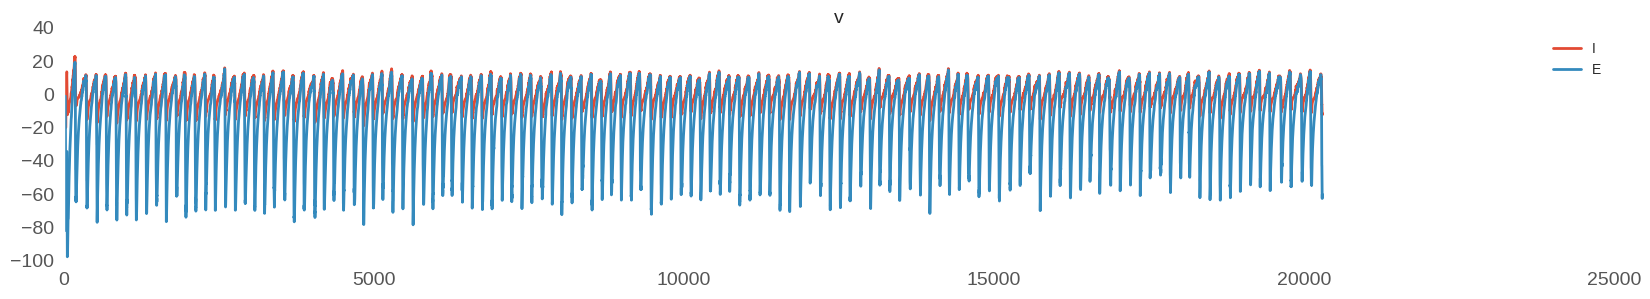

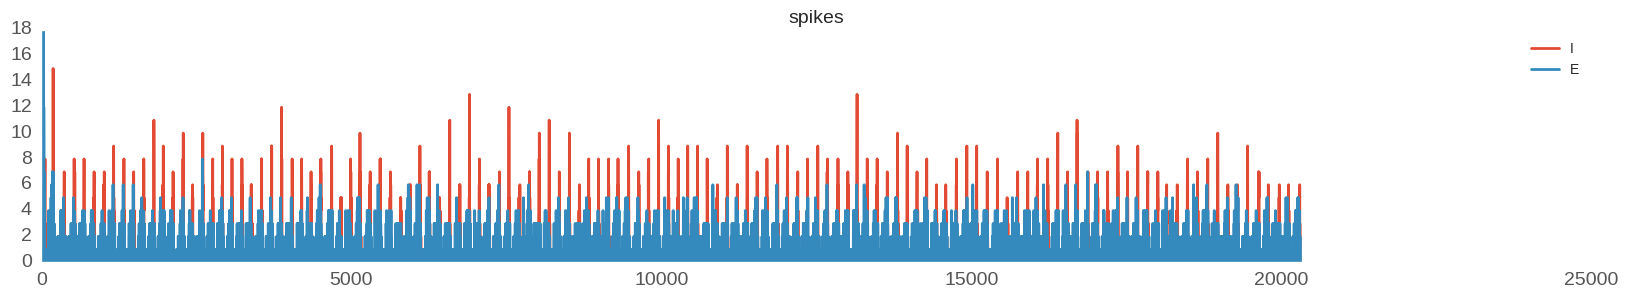

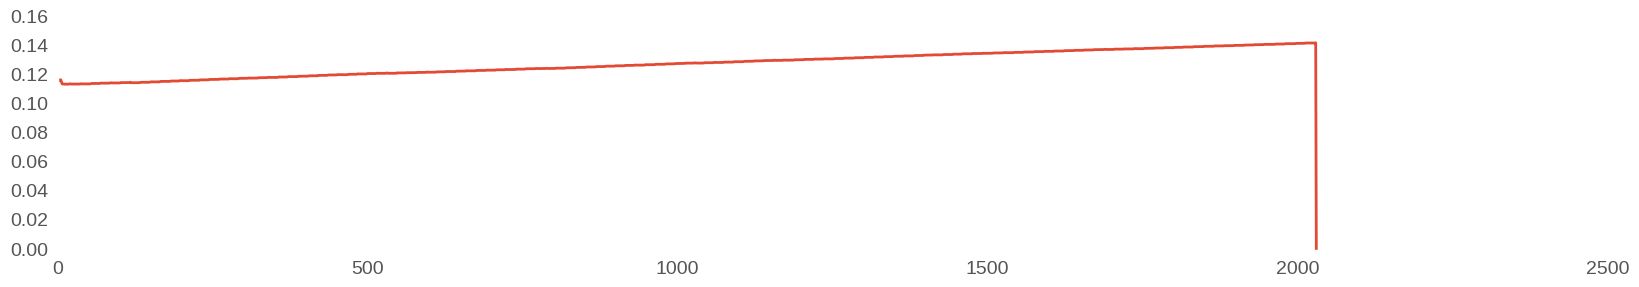

In [80]:

# plotRaster(gpu.raster)
# plt.xlim([19000,20000])
f()
plt.plot(gpu.icmI, label='I')
plt.plot(gpu.icmE, label='E')
plt.title('v')
plt.legend()

f()
plt.plot(gpu.vvmI, label='I')
plt.plot(gpu.vvmE, label='E')
plt.title('spikes')
plt.legend()

f()
plt.plot(gpu.gamma)

In [13]:
# plt.imshow(gpu.WII)
# plt.colorbar()
# plt.title('WII')
# f()
# plt.imshow(gpu.WEE)
# plt.colorbar()
# plt.title('WEE')
# f()
# plt.imshow(gpu.WIE)
# plt.colorbar()
# plt.title('WIE')
# f()
# plt.imshow(gpu.WEI)
# plt.colorbar()
# plt.title('WEI')

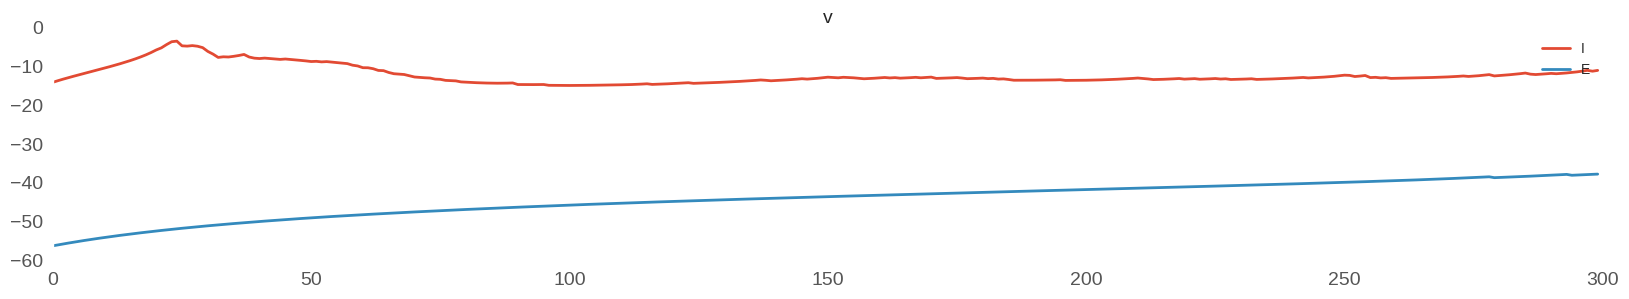

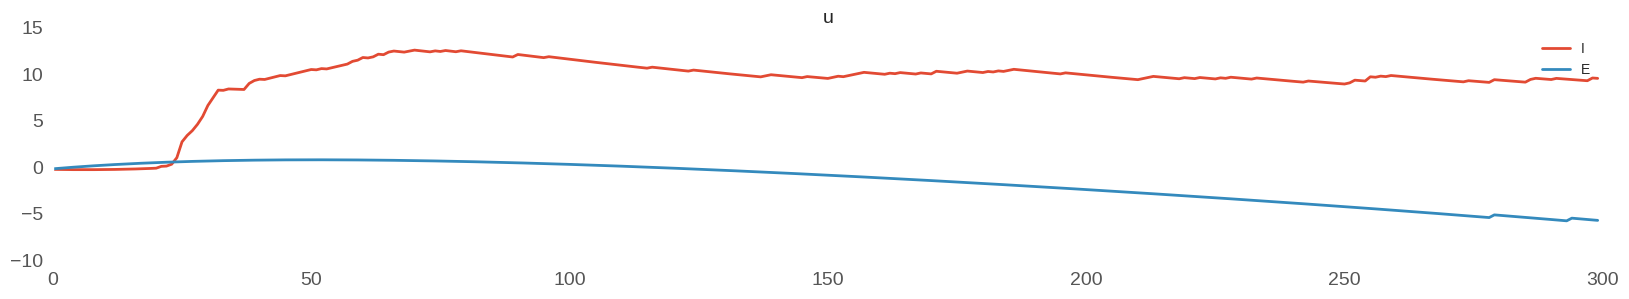

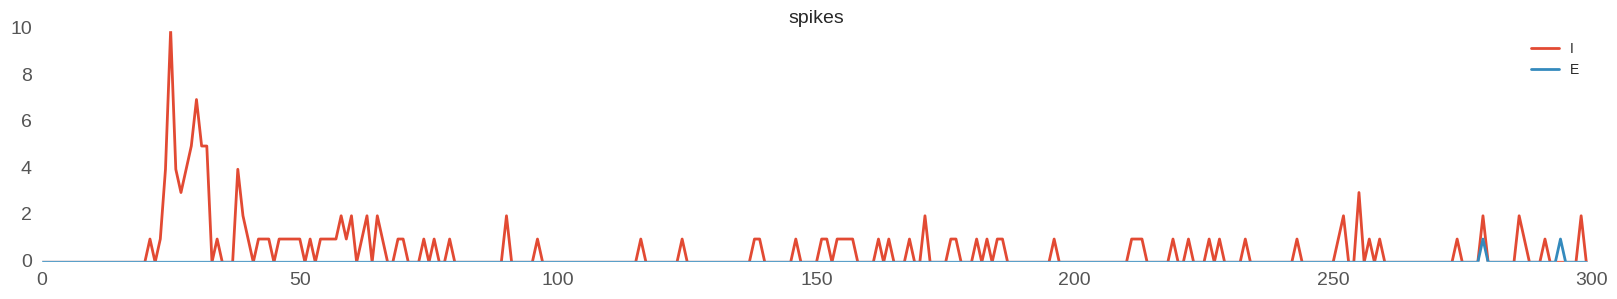

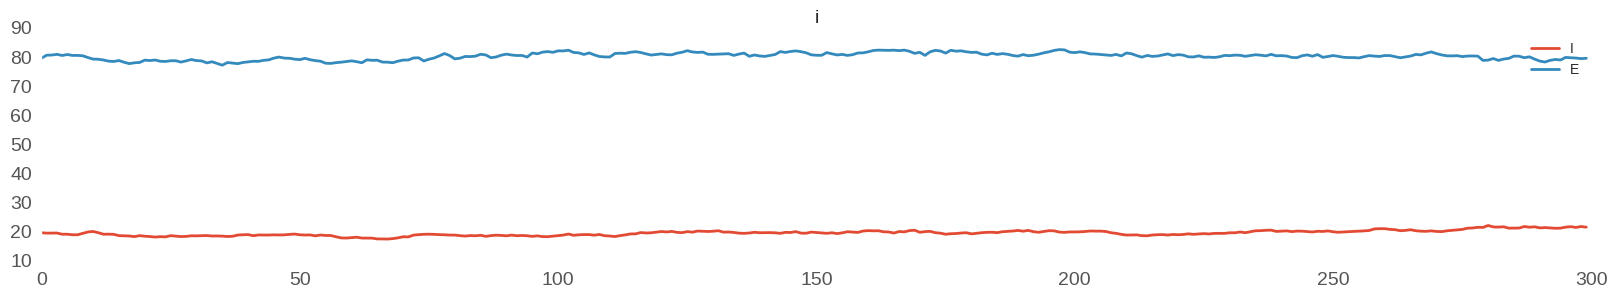

In [14]:
f()
plt.plot(gpu.vmI, label='I')
plt.plot(gpu.vmE, label='E')
plt.title('v')
plt.legend()

f()
plt.plot(gpu.umI, label='I')
plt.plot(gpu.umE, label='E')
plt.title('u')
plt.legend()

f()
plt.plot(gpu.vvmI, label='I')
plt.plot(gpu.vvmE, label='E')
plt.title('spikes')
plt.legend()

f()
plt.plot(gpu.imI, label='I')
plt.plot(gpu.imE, label='E')
plt.title('i')
plt.legend()